In [1]:
#Importing necessary libraries
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
torch.cuda.empty_cache()

# Define image preprocessing transformations
#
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]
    ),
])

In [ ]:
# Load pretrained ResNet50 model, remove classification head
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last fc layer
model.eval()

In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu")
model.to(device)

In [5]:
# Path to your images folder
image_folder = "/home/slakkaraju/flowers/flowers"

In [6]:
# Store embeddings and image paths
embeddings = []
image_paths = []

with torch.no_grad():
    for img_file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_file)
        try:
            image = Image.open(img_path).convert('RGB')
            input_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dim
            embedding = model(input_tensor)
            embedding = embedding.squeeze().cpu().numpy()  # Flatten to 1D vector
            embeddings.append(embedding)
            image_paths.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            
torch.cuda.empty_cache() 

embeddings = np.array(embeddings)

In [7]:
#Verifying values from 1st index
embeddings[0]

array([0.13846855, 0.35941505, 0.46692422, ..., 0.16873738, 0.12813622,
       0.03566949], shape=(2048,), dtype=float32)

In [8]:
# Save embeddings and paths for later use (e.g., numpy file or pickle)
np.save('flower_image_embeddings.npy', embeddings)
with open('image_paths.txt', 'w') as f:
    for path in image_paths:
        f.write(f"{path}\n")

print(f"Extracted embeddings for {len(embeddings)} images.")

Extracted embeddings for 13862 images.


In [9]:
# Load embeddings saved earlier
embeddings = np.load('flower_image_embeddings.npy')

# Define number of clusters (adjust based on your data)
num_clusters = 10

In [10]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

In [11]:
# Save cluster labels for each image
np.save('cluster_labels.npy', cluster_labels)
print("Clustering completed.")

Clustering completed.


In [12]:
# Load embeddings and cluster labels
embeddings = np.load('flower_image_embeddings.npy')
cluster_labels = np.load('cluster_labels.npy')

In [13]:
#Use PCA to reduce dimensionality before t-SNE for faster processing
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

In [14]:
# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_pca)

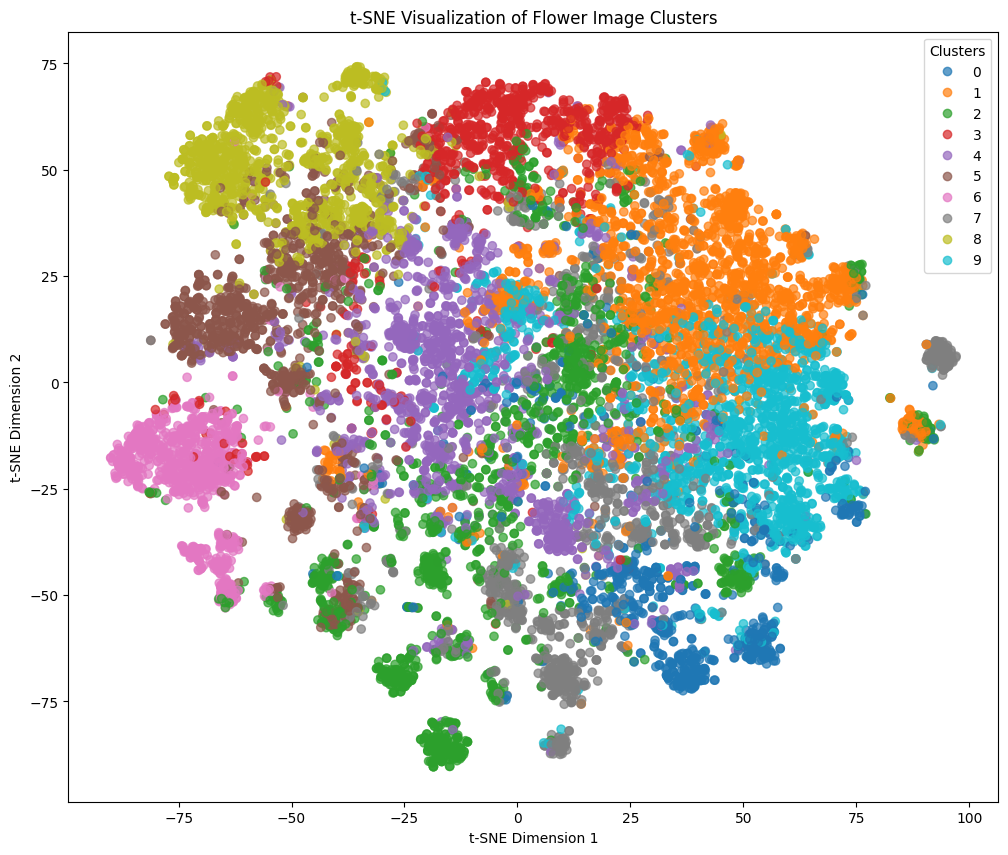

In [15]:
# Plot with clusters using different colors
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("t-SNE Visualization of Flower Image Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [16]:
# Connect to local Qdrant

from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct

client = QdrantClient(host='localhost', port=6333)

In [17]:
# Create collection (recreate if exists) with updated vectors_config parameter
collection_name = 'flower_images'
vectors_config = models.VectorParams(
    size=embeddings.shape[1],  # dimension of embeddings, e.g., 2048
    distance=models.Distance.COSINE  # or Euclid, Dot
)
client.recreate_collection(
    collection_name=collection_name,
    vectors_config=vectors_config
)

/tmp/ipykernel_171214/1123364067.py:7: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [18]:
# Load image paths and cluster labels
with open('image_paths.txt', 'r') as f:
    image_paths = [line.strip() for line in f]

# Prepare Qdrant points with payload (filepath and cluster)
points = [
    PointStruct(
        id=i,
        vector=embeddings[i].tolist(),
        payload={"filepath": image_paths[i], "cluster": int(cluster_labels[i])}
    )
    for i in range(len(embeddings))
]

In [19]:
# Upload points in batches
batch_size = 500
for i in range(0, len(points), batch_size):
    client.upsert(
        collection_name=collection_name,
        points=points[i:i+batch_size]
    )

print("Uploaded embeddings and metadata to Qdrant.")

Uploaded embeddings and metadata to Qdrant.


In [20]:
# Get the number of points in the collection
points_count = client.count(collection_name=collection_name)
print(f"Number of points in collection '{collection_name}': {points_count.count}")

Number of points in collection 'flower_images': 13862


In [21]:
# Get detailed collection info
collection_info = client.get_collection(collection_name=collection_name)
print(f"Collection '{collection_name}' info:")
print(collection_info)

Collection 'flower_images' info:
status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=None indexed_vectors_count=13500 points_count=13862 segments_count=8 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=2048, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=10000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_seg

In [22]:
#Get Embedding for the Query image, use the same pretrained model and preprocessing to create the embeddings. 
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(input_tensor).squeeze().cpu().numpy()
    return embedding


In [23]:
#Query nearest neighbor
from qdrant_client import QdrantClient

client = QdrantClient(host='localhost', port=6333)
collection_name = 'flower_images'

query_image_path = '/home/slakkaraju/flowers/flowers/5547758_eea9edfd54_n.jpg'
query_embedding = get_embedding(query_image_path).tolist()

# Retrieve top 5 nearest neighbors
search_result = client.search(
    collection_name=collection_name,
    query_vector=query_embedding,
    limit=5
)

print("Nearest Neighbors:")
for point in search_result:
    print(f"ID: {point.id}, Score: {point.score:.4f}, Filepath: {point.payload['filepath']}, Cluster: {point.payload['cluster']}")


Nearest Neighbors:
ID: 1681, Score: 0.9760, Filepath: /home/slakkaraju/flowers/flowers/5547758_eea9edfd54_n.jpg, Cluster: 5
ID: 1294, Score: 0.9102, Filepath: /home/slakkaraju/flowers/flowers/7377004908_5bc0cde347_n.jpg, Cluster: 5
ID: 7424, Score: 0.8900, Filepath: /home/slakkaraju/flowers/flowers/18442919723_d1251d3e14_n.jpg, Cluster: 5
ID: 7980, Score: 0.8889, Filepath: /home/slakkaraju/flowers/flowers/3939135368_0af5c4982a_n.jpg, Cluster: 5
ID: 3213, Score: 0.8857, Filepath: /home/slakkaraju/flowers/flowers/1798082733_b8080b1173_m.jpg, Cluster: 5


/tmp/ipykernel_171214/3620603704.py:11: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


/tmp/ipykernel_171214/3985330058.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


Nearest Neighbors excluding query image:
ID: 4123, Score: 0.8283, Filepath: /home/slakkaraju/flowers/flowers/image_07864.jpg, Cluster: 7
ID: 5888, Score: 0.8265, Filepath: /home/slakkaraju/flowers/flowers/3430229687_32645b5738.jpg, Cluster: 2
ID: 5290, Score: 0.8224, Filepath: /home/slakkaraju/flowers/flowers/2426847695_4b8409402e_n.jpg, Cluster: 2
ID: 7630, Score: 0.8180, Filepath: /home/slakkaraju/flowers/flowers/16309287412_5cc4d58bd1_n.jpg, Cluster: 2
ID: 3024, Score: 0.8136, Filepath: /home/slakkaraju/flowers/flowers/8586204750_2891bd2ec9_n.jpg, Cluster: 2
ID: 679, Score: 0.8060, Filepath: /home/slakkaraju/flowers/flowers/image_0105.jpg, Cluster: 2
ID: 9719, Score: 0.8048, Filepath: /home/slakkaraju/flowers/flowers/4117620896_070e5887ae_m.jpg, Cluster: 2
ID: 13295, Score: 0.8037, Filepath: /home/slakkaraju/flowers/flowers/16074109313_2cc14c7d16.jpg, Cluster: 2
ID: 1086, Score: 0.8029, Filepath: /home/slakkaraju/flowers/flowers/image_00444.jpg, Cluster: 7


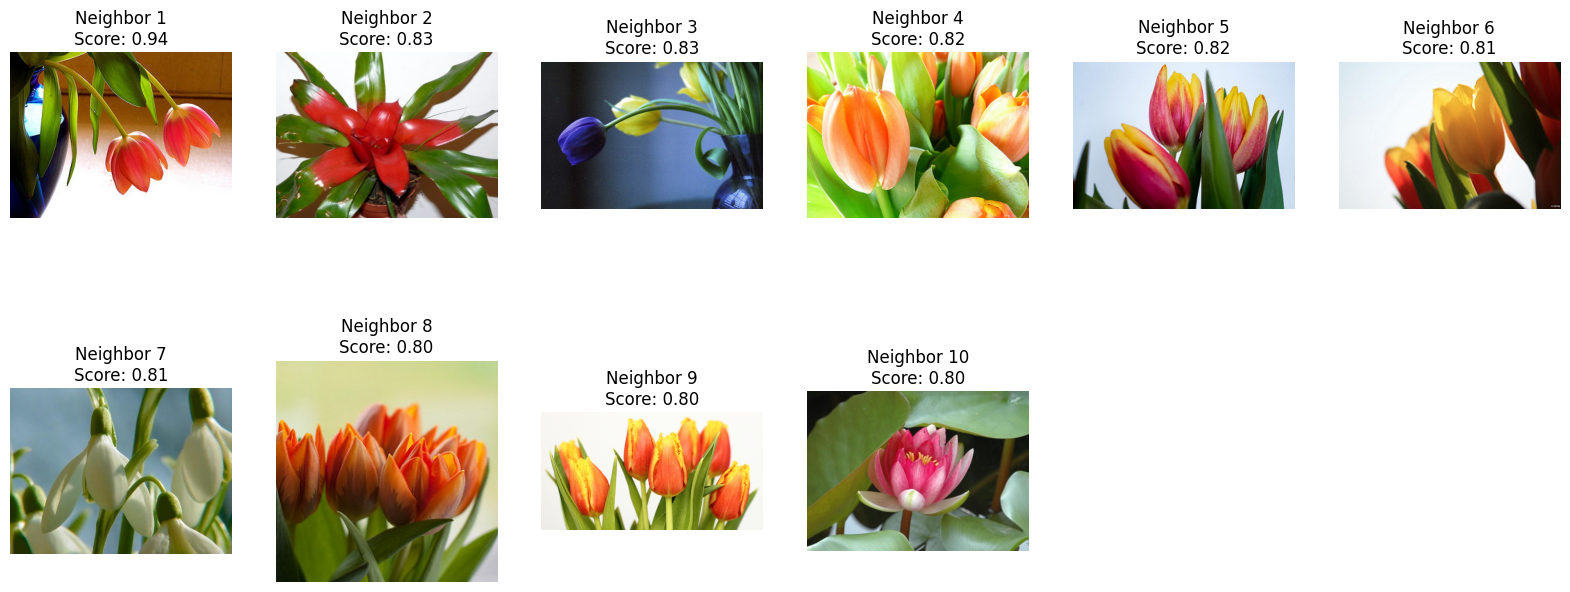

In [24]:
#Querying 10 nearest neighbors along with the actual images. 
query_image_path = '/home/slakkaraju/flowers/flowers/116343334_9cb4acdc57_n.jpg'
query_embedding = get_embedding(query_image_path).tolist()

# Retrieve top 10 neighbors to be safe
search_result = client.search(
    collection_name=collection_name,
    query_vector=query_embedding,
    limit=10  # get more results to compensate for filtering
)

# Filter out the query image itself
filtered_results = [point for point in search_result if point.payload['filepath'] != query_image_path]

# Select top 10 excluding the query image
top_neighbors = filtered_results[:10]

print("Nearest Neighbors excluding query image:")
for point in top_neighbors:
    print(f"ID: {point.id}, Score: {point.score:.4f}, Filepath: {point.payload['filepath']}, Cluster: {point.payload['cluster']}")

plt.figure(figsize=(20, 8))

# Show query image first
query_img = Image.open(query_image_path)
plt.subplot(2, 6, 1)
plt.imshow(query_img)
plt.title("Query Image")
plt.axis('off')

# Show nearest neighbor images
for i, point in enumerate(search_result):
    neighbor_img_path = point.payload['filepath']
    neighbor_img = Image.open(neighbor_img_path)
    plt.subplot(2, 6, i + 1)
    plt.imshow(neighbor_img)
    plt.title(f"Neighbor {i + 1}\nScore: {point.score:.2f}")
    plt.axis('off')

plt.show()

In [25]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load BLIP model
processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def generate_caption_blip(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor_blip(images=image, return_tensors="pt").to(device)
    out = model_blip.generate(**inputs)
    return processor_blip.decode(out[0], skip_special_tokens=True)

/home/slakkaraju/flowers/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 10034.22it/s]


In [26]:
# Example flower image path
image_path = '/home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg'

# Generate caption from image
caption = generate_caption_blip(image_path)
print("BLIP Caption:", caption)

BLIP Caption: a yellow rose flower with a white background


In [27]:
# For each point:
caption = generate_caption_blip(image_path)
client.set_payload(
    collection_name=collection_name,
    payload={"caption": caption},
    points=[point.id]
)

UpdateResult(operation_id=28, status=<UpdateStatus.COMPLETED: 'completed'>)

### RAG Inference: Get Neighbors and Ask LLM

In [28]:
#Get Embedding for Query Image
#Use the same embedding method you indexed in Qdrant.
query_embedding = get_embedding(query_image_path)  # Should return np.array


In [29]:
#Retrieve top n neighbors
top_n = 10
results = client.search(
    collection_name=collection_name,
    query_vector=query_embedding.tolist(),
    limit=top_n
)
neighbors = [
    {"filepath": p.payload.get("filepath", ""), "caption": p.payload.get("caption", "")}
    for p in results
]



/tmp/ipykernel_171214/2354394943.py:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = client.search(


In [30]:
def get_top_neighbors(query_embedding, client, collection_name, top_n=10):
    """
    Retrieve the nearest neighbor points from Qdrant and extract their
    filepath and caption.

    Args:
        query_embedding (np.ndarray): Embedding of the query image.
        client (QdrantClient): Initialized Qdrant client.
        collection_name (str): Name of the Qdrant collection.
        top_n (int): Number of neighbors to retrieve.

    Returns:
        List[dict]: Each dict with 'filepath' and 'caption' keys.
    """
    results = client.search(
        collection_name=collection_name,
        query_vector=query_embedding.tolist(),
        limit=top_n
    )
    neighbors = [
        {
            "filepath": p.payload.get("filepath", ""), 
            "caption": p.payload.get("caption", "")
        }
        for p in results
    ]
    return neighbors


In [31]:
context = "\n".join(f"- {n['caption']}" for n in neighbors)
prompt = (
    f"Context from visually similar flower images:\n"
    f"{context}\n"
    f"User question: {"Describe this image, capture relevant details, how this can be taken care of, and where is it usually found"}\n"
    f"Answer as a helpful botanist."
)


In [32]:
from openai import OpenAI
import os
openai_client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def query_gpt4(prompt):
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful botanist."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=400
    )
    return response.choices[0].message.content.strip()

llm_response = query_gpt4(prompt)
print(llm_response)


The image you are describing seems to feature a yellow rose with a white background. Below is a detailed description and care guide for yellow roses, as well as their typical habitat and distribution:

### Description:
- **Appearance**: Yellow roses are characterized by their vibrant and cheerful yellow petals. They can vary in shade from pale to deep yellow. Their structure typically features a classic rose bloom shape with layers of petals that unfurl gracefully.
- **Stem and Leaves**: The stems of rose plants are usually thorny, and their leaves are usually a dark green color with a serrated edge.
- **Fragrance**: Many yellow roses have a light, pleasant fragrance, though the strength of scent can vary by variety.

### Care Guide:
- **Light**: Yellow roses require full sun, which means they need at least 6 to 8 hours of direct sunlight per day. This ensures healthy growth and vibrant blooms.
- **Soil**: They thrive in well-drained, fertile soil with a slightly acidic to neutral pH. 

In [33]:
from PIL import Image
import matplotlib.pyplot as plt

def show_images(image_paths, titles=None):
    num_images = len(image_paths)
    plt.figure(figsize=(3 * num_images, 3))
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[i], fontsize=10)
    plt.show()

def display_query_and_rag_results(
    query_image_path,
    get_embedding,
    get_top_neighbors,
    generate_caption,
    query_gpt4,
    user_question,
    top_n=5
):
    # Step 1: Get query embedding and caption
    query_embedding = get_embedding(query_image_path)
    query_caption = generate_caption(query_image_path)

    # Step 2: Find neighbors
    neighbors = get_top_neighbors(
    query_embedding=query_embedding,
    client=client,
    collection_name=collection_name,
    top_n=10
)

    # Step 3: Build LLM prompt
    context_lines = [f"- {item['caption']}" for item in neighbors if item["caption"]]
    context_lines.insert(0, f"[Query Image Caption] {query_caption}")
    context_text = "\n".join(context_lines)
    prompt = (
        f"Here are the captions of similar flower images:\n{context_text}\n"
        f"User question: {"Describe this image, capture relevant details, how this can be taken care of, and where is it usually found"}\n"
        f"Answer as a helpful botanist."
    )
    # Step 4: Get LLM response
    llm_response = query_gpt4(prompt)

    # Step 5: Display query image
    print(f"Query Image: {query_image_path}")
    show_images([query_image_path], titles=["Query Image"])

    # Step 6: Display neighbors
    print("\nNearest Neighbors:")
    neighbor_paths = [item["filepath"] for item in neighbors]
    neighbor_titles = [f"Neighbor {i+1}" for i in range(len(neighbor_paths))]
    for i, (path, caption) in enumerate(zip(neighbor_paths, [item["caption"] for item in neighbors])):
        print(f"[Neighbor {i+1}] {path}: {caption}")
    show_images(neighbor_paths, titles=neighbor_titles)

    # Step 7: Print LLM response
    print("\nLLM (GPT-4) Response:\n" + llm_response)


/tmp/ipykernel_171214/1836309822.py:15: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = client.search(


Query Image: /home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg


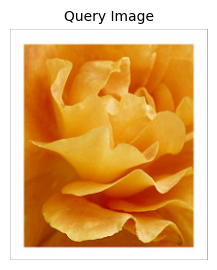


Nearest Neighbors:
[Neighbor 1] /home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg: 
[Neighbor 2] /home/slakkaraju/flowers/flowers/2535495431_e6f950443c.jpg: 
[Neighbor 3] /home/slakkaraju/flowers/flowers/9216323421_f737c1d50e.jpg: 
[Neighbor 4] /home/slakkaraju/flowers/flowers/4860145119_b1c3cbaa4e_n.jpg: 
[Neighbor 5] /home/slakkaraju/flowers/flowers/1793211631_68c31a74dc.jpg: 
[Neighbor 6] /home/slakkaraju/flowers/flowers/image_01231.jpg: 
[Neighbor 7] /home/slakkaraju/flowers/flowers/527513005_41497ca4dc.jpg: 
[Neighbor 8] /home/slakkaraju/flowers/flowers/6732261031_861a1026fa_n.jpg: 
[Neighbor 9] /home/slakkaraju/flowers/flowers/image_01201.jpg: 
[Neighbor 10] /home/slakkaraju/flowers/flowers/image_01224.jpg: 


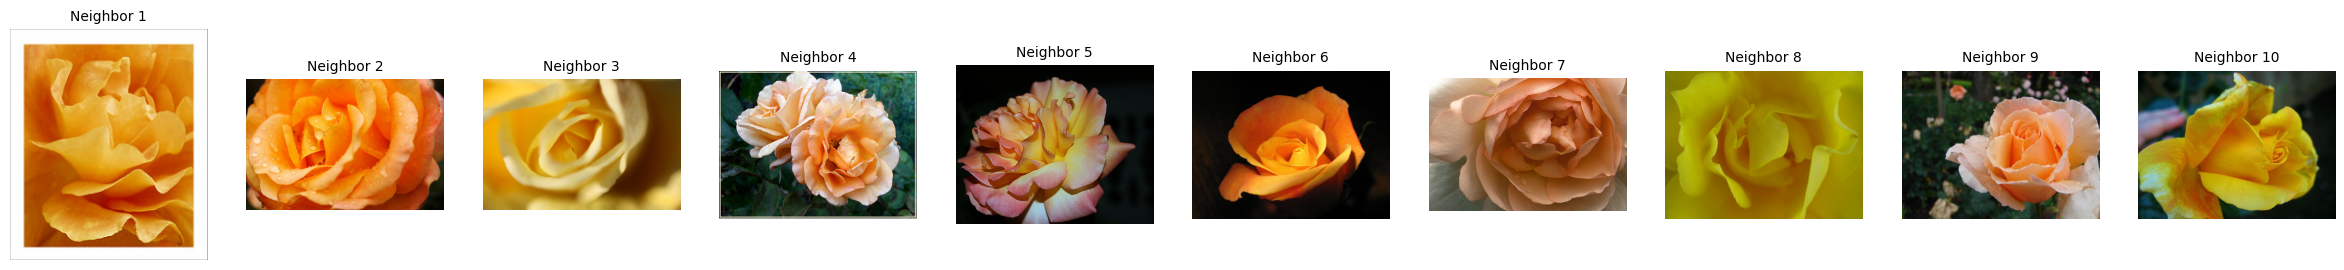


LLM (GPT-4) Response:
Based on the caption you provided, the query image features a yellow rose with a white background. Here is a detailed description, care instructions, and information about the natural habitat of yellow roses:

### Description:
- **Appearance**: The image likely shows a single yellow rose flower. Yellow roses are admired for their bright, cheerful color and are commonly associated with feelings of joy and friendship.
- **Bloom Structure**: The bloom typically consists of multiple layers of soft, velvety petals that spiral tightly towards the center.
- **Stem and Leaves**: Though not visible in a close-up image of just the flower, rose stems usually have thorns, and the leaves are pinnately compound with a glossy, dark green appearance.

### Care Instructions:
- **Sunlight**: Yellow roses require full sunlight for about six to eight hours a day to thrive and bloom well.
- **Soil**: They prefer well-drained, loamy, and slightly acidic soil with a pH between 6.0 and 

In [34]:
query_image_path = '/home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg'
user_question = "What is this flower and how do I care for it?"

display_query_and_rag_results(
    query_image_path=query_image_path,
    get_embedding=get_embedding,                # Your embedding function
    get_top_neighbors = get_top_neighbors, # Your neighbor search function
    generate_caption=generate_caption_blip,     # Your BLIP caption function
    query_gpt4=query_gpt4,                      # Your OpenAI LLM call
    user_question=user_question,
    top_n=5
)

/tmp/ipykernel_171214/1836309822.py:15: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = client.search(


Query Image: /home/slakkaraju/flowers/flowers/1244774242_25a20d99a9.jpg


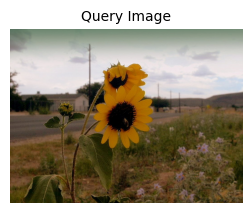


Nearest Neighbors:
[Neighbor 1] /home/slakkaraju/flowers/flowers/1244774242_25a20d99a9.jpg: 
[Neighbor 2] /home/slakkaraju/flowers/flowers/5995136822_8e1eed76f5_n.jpg: 
[Neighbor 3] /home/slakkaraju/flowers/flowers/2697194548_ec8f8de97c_n.jpg: 
[Neighbor 4] /home/slakkaraju/flowers/flowers/5043409856_395300dbe5_m.jpg: 
[Neighbor 5] /home/slakkaraju/flowers/flowers/8705462313_4458d64cd4.jpg: 
[Neighbor 6] /home/slakkaraju/flowers/flowers/7176736574_14446539cb_n.jpg: 
[Neighbor 7] /home/slakkaraju/flowers/flowers/2442985637_8748180f69.jpg: 
[Neighbor 8] /home/slakkaraju/flowers/flowers/5994569021_749d5e2da3_n.jpg: 
[Neighbor 9] /home/slakkaraju/flowers/flowers/4871455214_8b5fb87ab6_n.jpg: 
[Neighbor 10] /home/slakkaraju/flowers/flowers/3466923719_b4b6df7f8b_n.jpg: 


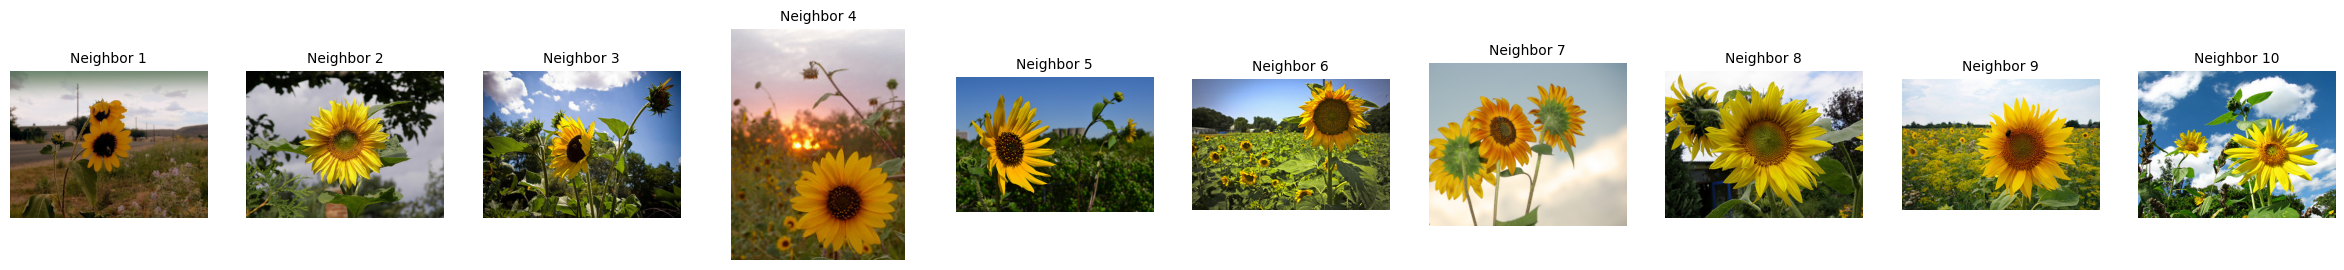


LLM (GPT-4) Response:
To describe the image you provided, the yellow flower likely stands out amidst a field, suggesting it may belong to a wildflower species that naturally occurs or thrives in such environments. Yellow flowers are commonly found among several genera including daisies, sunflowers, dandelions, and buttercups.

Key details to capture from this description are:
1. **Color**: The bright yellow color of the flower is both visually striking and implies certain botanical species that commonly exhibit such coloration.
2. **Habitat**: A field environment suggests the plant is likely adapted to open, sunny conditions with well-drained soil, typically characteristics of wildflowers.
3. **Solitary Bloom**: The mention of a single flower could indicate a species where individual plants are spaced apart or one where each plant produces singular, prominent flowers.

**Care and Maintenance**:
- **Sunlight**: Most yellow field flowers favor full sunlight, as they naturally grow in op

In [35]:
query_image_path = '/home/slakkaraju/flowers/flowers/1244774242_25a20d99a9.jpg'
user_question = "What is this flower and how do I care for it?"

display_query_and_rag_results(
    query_image_path=query_image_path,
    get_embedding=get_embedding,                # Your embedding function
    get_top_neighbors = get_top_neighbors, # Your neighbor search function
    generate_caption=generate_caption_blip,     # Your BLIP caption function
    query_gpt4=query_gpt4,                      # Your OpenAI LLM call
    user_question=user_question,
    top_n=5
)

/tmp/ipykernel_171214/1836309822.py:15: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = client.search(


Query Image: /home/slakkaraju/flowers/flowers/image_01123.jpg


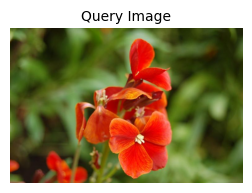


Nearest Neighbors:
[Neighbor 1] /home/slakkaraju/flowers/flowers/image_01123.jpg: 
[Neighbor 2] /home/slakkaraju/flowers/flowers/image_01016.jpg: 
[Neighbor 3] /home/slakkaraju/flowers/flowers/image_01072.jpg: 
[Neighbor 4] /home/slakkaraju/flowers/flowers/image_00955.jpg: 
[Neighbor 5] /home/slakkaraju/flowers/flowers/image_01071.jpg: 
[Neighbor 6] /home/slakkaraju/flowers/flowers/image_01054.jpg: 
[Neighbor 7] /home/slakkaraju/flowers/flowers/image_01124.jpg: 
[Neighbor 8] /home/slakkaraju/flowers/flowers/image_00981.jpg: 
[Neighbor 9] /home/slakkaraju/flowers/flowers/image_01125.jpg: 
[Neighbor 10] /home/slakkaraju/flowers/flowers/image_01073.jpg: 


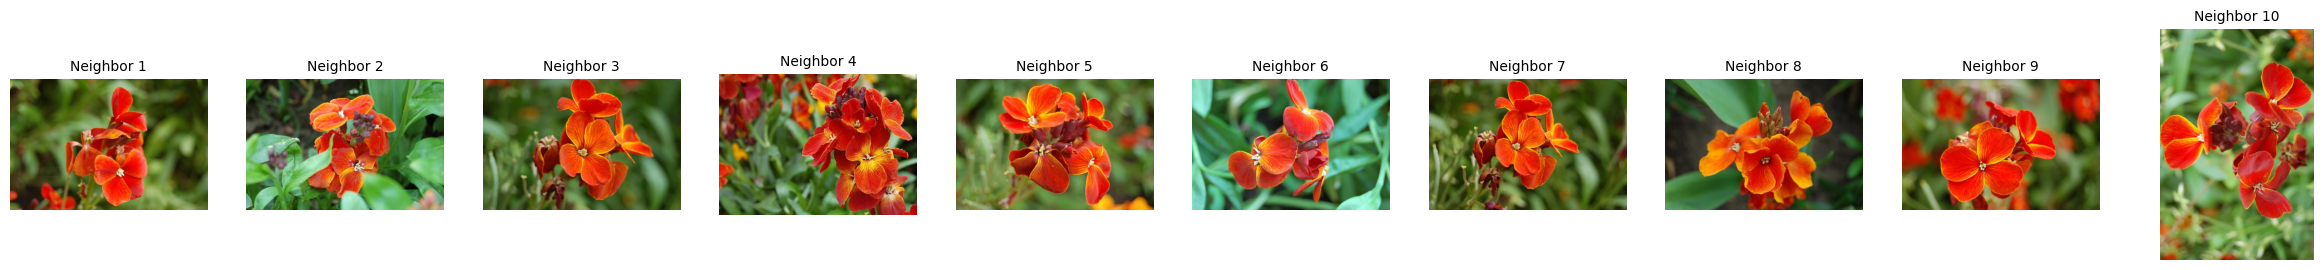


LLM (GPT-4) Response:
To describe a red flower in a garden, we need to consider several different aspects such as its appearance, likely species, and care requirements. Here’s a structured botanical answer:

### Description:
1. **Appearance:**
   - **Color:** A prominent red hue is the primary feature, which could indicate that the flower is possibly a rose, tulip, geranium, or hibiscus as these species frequently have red variations.
   - **Form:** The petal structure and count can provide more hints. Roses have a spiral of petals, tulips have a bulbous shape, and hibiscus flowers are typically large with a prominent stamen.

2. **Environment:**
   - **Location:** Mentioned in a garden, which suggests it’s growing in a cultivated setting, likely among other ornamental plants.
   - **Condition:** Often in gardens, plants are well-tended, receiving ample sunlight, water, and nutrients from fertilized soil.

### Care Instructions:
1. **Watering:** Most garden flowers benefit from regula

In [36]:
query_image_path = '/home/slakkaraju/flowers/flowers/image_01123.jpg'
user_question = "What is this flower and how do I care for it?"

display_query_and_rag_results(
    query_image_path=query_image_path,
    get_embedding=get_embedding,                # Your embedding function
    get_top_neighbors = get_top_neighbors, # Your neighbor search function
    generate_caption=generate_caption_blip,     # Your BLIP caption function
    query_gpt4=query_gpt4,                      # Your OpenAI LLM call
    user_question=user_question,
    top_n=5
)

/tmp/ipykernel_171214/1836309822.py:15: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = client.search(


Query Image: /home/slakkaraju/flowers/flowers/image_00011.jpg


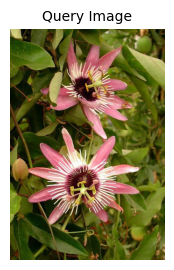


Nearest Neighbors:
[Neighbor 1] /home/slakkaraju/flowers/flowers/image_00011.jpg: 
[Neighbor 2] /home/slakkaraju/flowers/flowers/image_00048.jpg: 
[Neighbor 3] /home/slakkaraju/flowers/flowers/image_00163.jpg: 
[Neighbor 4] /home/slakkaraju/flowers/flowers/image_00230.jpg: 
[Neighbor 5] /home/slakkaraju/flowers/flowers/image_00126.jpg: 
[Neighbor 6] /home/slakkaraju/flowers/flowers/image_00018.jpg: 
[Neighbor 7] /home/slakkaraju/flowers/flowers/image_00079.jpg: 
[Neighbor 8] /home/slakkaraju/flowers/flowers/image_00131.jpg: 
[Neighbor 9] /home/slakkaraju/flowers/flowers/image_03844.jpg: 
[Neighbor 10] /home/slakkaraju/flowers/flowers/image_00225.jpg: 


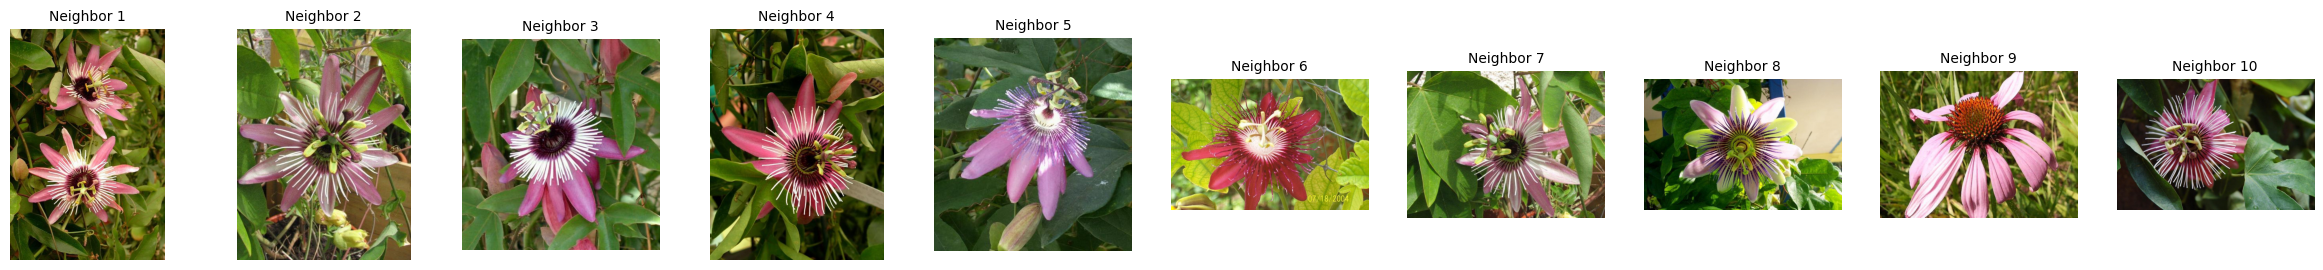


LLM (GPT-4) Response:
To accurately describe and identify the flower in the image you are referring to, more detailed information would be helpful. However, I can provide a general approach to describing flower images and offer care tips and habitat information for common flowers.

### Describing the Image:
1. **Petal Structure**: Note the number of petals and their shape. Are they round, pointed, fringed, or lobed?
2. **Color**: Describe the primary color and any variegations or patterns. Are there gradients or spots?
3. **Size**: If possible, provide an estimate of the flower's size.
4. **Center**: Describe the center of the flower. Does it have a prominent stamen or pistil? Are there any noticeable pollen grains?
5. **Leaves and Stem**: Note the type and shape of the leaves, and describe the stem's texture (e.g., smooth, fuzzy, thorny).

### General Care Tips:
- **Watering**: Most flowers prefer evenly moist soil. However, ensure the species' specific needs as some prefer drier con

In [37]:
query_image_path = '/home/slakkaraju/flowers/flowers/image_00011.jpg'
user_question = "What is this flower and how do I care for it?"

display_query_and_rag_results(
    query_image_path=query_image_path,
    get_embedding=get_embedding,                # Your embedding function
    get_top_neighbors = get_top_neighbors, # Your neighbor search function
    generate_caption=generate_caption_blip,     # Your BLIP caption function
    query_gpt4=query_gpt4,                      # Your OpenAI LLM call
    user_question=user_question,
    top_n=5
)